### 나이브베이즈를 활용한 유사 문서 검색

In [1]:
from sklearn.datasets import fetch_20newsgroups

categories = ['alt.atheism', 'soc.religion.christian', 'comp.graphics', 'sci.med']
twenty_train = fetch_20newsgroups(subset='train',
                                  categories=categories, shuffle=True,
                                  random_state=13)

In [2]:
twenty_train.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [3]:
print(twenty_train['DESCR'])

.. _20newsgroups_dataset:

The 20 newsgroups text dataset
------------------------------

The 20 newsgroups dataset comprises around 18000 newsgroups posts on
20 topics split in two subsets: one for training (or development)
and the other one for testing (or for performance evaluation). The split
between the train and test set is based upon a messages posted before
and after a specific date.

This module contains two loaders. The first one,
:func:`sklearn.datasets.fetch_20newsgroups`,
returns a list of the raw texts that can be fed to text feature
extractors such as :class:`~sklearn.feature_extraction.text.CountVectorizer`
with custom parameters so as to extract feature vectors.
The second one, :func:`sklearn.datasets.fetch_20newsgroups_vectorized`,
returns ready-to-use features, i.e., it is not necessary to use a feature
extractor.

**Data Set Characteristics:**

    =================   ==========
    Classes                     20
    Samples total            18846
    Dimensionality

In [4]:
twenty_train.target_names

['alt.atheism', 'comp.graphics', 'sci.med', 'soc.religion.christian']

In [5]:
len(twenty_train.data)

2257

In [6]:
print(twenty_train.data[0])

From: geb@cs.pitt.edu (Gordon Banks)
Subject: Re: Update (Help!) [was "What is This [Is it Lyme's?]"]
Article-I.D.: pitt.19436
Reply-To: geb@cs.pitt.edu (Gordon Banks)
Organization: Univ. of Pittsburgh Computer Science
Lines: 42

In article <1993Mar29.181958.3224@equator.com> jod@equator.com (John Setel O'Donnell) writes:
>
>I shouldn't have to be posting here.  Physicians should know the Lyme
>literature beyond Steere & co's denial merry-go-round.  Patients
>should get correctly diagnosed and treated.
>

Why do you think Steere is doing this?  Isn't he acting in good faith?
After all, as the "discoverer" of Lyme for all intents and purposes,
the more famous Lyme gets, the more famous Steere gets.  I don't
see the ulterior motive here.  It is easy for me to see it the
those physicians who call everything lyme and treat everything.
There is a lot of money involved.

>I'm a computer engineer, not a doctor (,Jim).  I was building a 
>computer manufacturing company when I got Lyme. I lost 

In [7]:
print(twenty_train.target_names[twenty_train.target[0]])

sci.med


In [8]:
twenty_train.target[:10]

array([2, 1, 1, 3, 2, 3, 0, 3, 2, 0])

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(twenty_train.data)
X_train_counts.shape

(2257, 35788)

In [10]:
X_train_counts.toarray()[0]

array([0, 0, 0, ..., 0, 0, 0])

In [11]:
len(X_train_counts.toarray()[0])

35788

In [12]:
import numpy as np

np.sum(X_train_counts.toarray()[0])

320

In [13]:
from sklearn.feature_extraction.text import TfidfTransformer

tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
X_train_tf.shape

(2257, 35788)

In [14]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tf, twenty_train.target)

In [15]:
docs_new = ['God is love', 'OpenGL on the GPU is fast']
X_new_counts = count_vect.transform(docs_new)
X_new_tfidf = tf_transformer.transform(X_new_counts)

predicted = clf.predict(X_new_tfidf)

for doc, category in zip(docs_new, predicted):
    print('%r => %s' % (doc, twenty_train.target_names[category]))

'God is love' => soc.religion.christian
'OpenGL on the GPU is fast' => comp.graphics


In [16]:
from sklearn.pipeline import Pipeline

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

In [17]:
text_clf.fit(twenty_train.data, twenty_train.target)

twenty_test = fetch_20newsgroups(subset='test',
                                 categories=categories, shuffle=True,
                                 random_state=13)
docs_test = twenty_test.data
predicted = text_clf.predict(docs_test)
np.mean(predicted==twenty_test.target)

0.8348868175765646

In [18]:
from sklearn.metrics import classification_report

print(classification_report(twenty_test.target, predicted,
                           target_names=twenty_test.target_names))

                        precision    recall  f1-score   support

           alt.atheism       0.97      0.60      0.74       319
         comp.graphics       0.96      0.89      0.92       389
               sci.med       0.97      0.81      0.88       396
soc.religion.christian       0.65      0.99      0.78       398

              accuracy                           0.83      1502
             macro avg       0.89      0.82      0.83      1502
          weighted avg       0.88      0.83      0.84      1502



In [19]:
from sklearn.metrics import confusion_matrix

confusion_matrix(twenty_test.target, predicted)

array([[192,   2,   6, 119],
       [  2, 347,   4,  36],
       [  2,  11, 322,  61],
       [  2,   2,   1, 393]])

### SMS Spam Collection Dataset

In [20]:
import pandas as pd

messages = pd.read_csv('./Downloads/spam.csv', encoding='latin-1')
messages.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)
messages = messages.rename(columns={'v1' : 'class', 'v2' : 'text'})
messages.head()

,class,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [21]:
messages.groupby('class').describe()

text                                                               
      count unique                                                top freq
class                                                                     
ham    4825   4516                             Sorry, I'll call later   30
spam    747    653  Please call our customer service representativ...    4

In [22]:
messages['length'] = messages['text'].apply(len)
messages.head()

,class,text,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


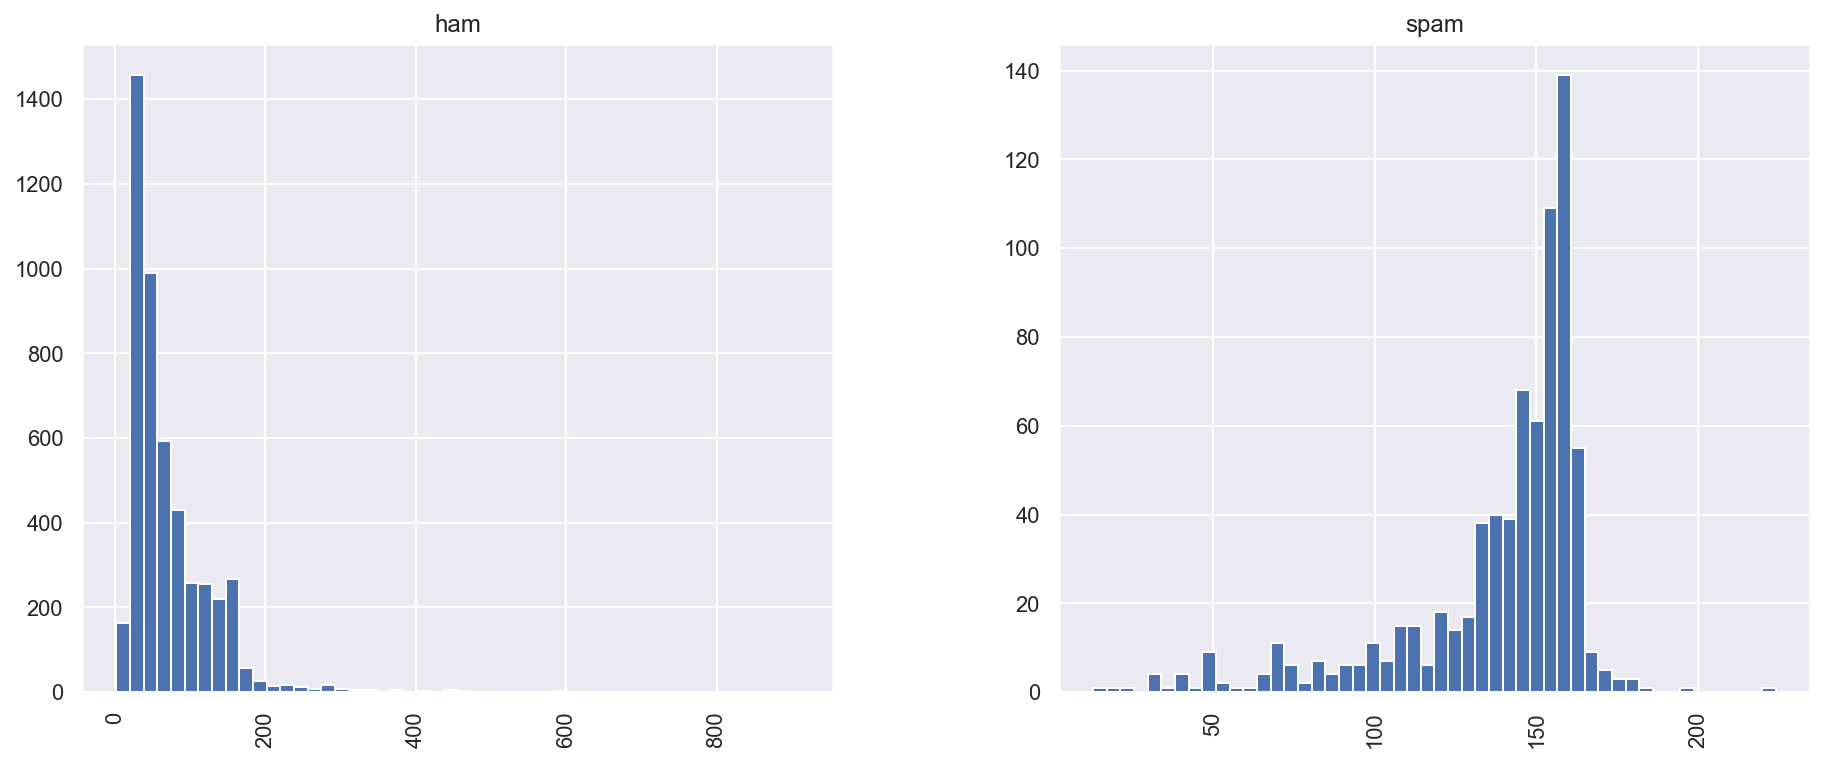

In [23]:
messages.hist(column='length', by='class', bins=50, figsize=(15,6));

In [24]:
import string
from nltk.corpus import stopwords

def process_text(text):
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    clean_words = [word for word in nopunc.split()
                   if word.lower() not in stopwords.words('english')]
    
    return clean_words

In [25]:
messages['text'].apply(process_text).head()

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: text, dtype: object

In [26]:
from sklearn.model_selection import train_test_split

msg_train, msg_test, class_train, class_test =\
        train_test_split(messages['text'], messages['class'], test_size=0.2)

In [27]:
pipeline = Pipeline([
    ('vect', CountVectorizer(analyzer=process_text)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB())
])

In [28]:
pipeline.fit(msg_train, class_train)

Pipeline(steps=[('vect',
                 CountVectorizer(analyzer=<function process_text at 0x7fa349212d40>)),
                ('tfidf', TfidfTransformer()), ('clf', MultinomialNB())])

In [29]:
predictions = pipeline.predict(msg_test)

In [30]:
print(classification_report(class_test, predictions))

              precision    recall  f1-score   support

         ham       0.96      1.00      0.98       965
        spam       1.00      0.75      0.85       150

    accuracy                           0.97      1115
   macro avg       0.98      0.87      0.92      1115
weighted avg       0.97      0.97      0.96      1115



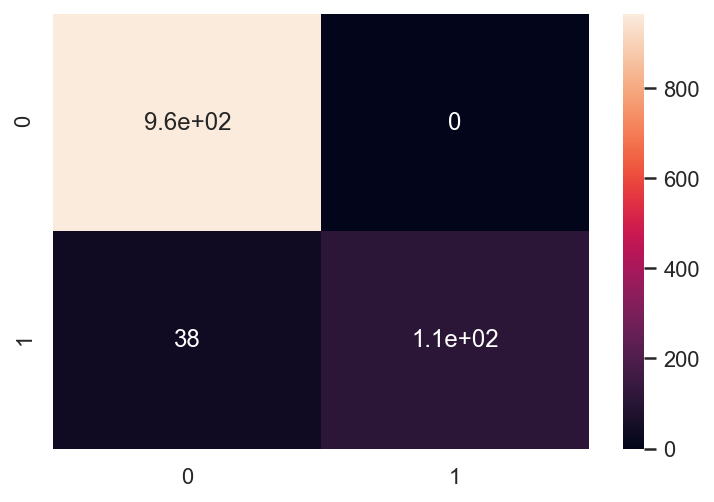

In [31]:
import seaborn as sns
sns.heatmap(confusion_matrix(class_test, predictions), annot=True);

### 네이버 영화 평점을 이용한 감성 분석

In [32]:
import pandas as pd

train_df = pd.read_csv('./Downloads/ratings_train.txt', sep='\t')
train_df.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [33]:
train_df['label'].value_counts()

0    75173
1    74827
Name: label, dtype: int64

In [34]:
import re

train_df = train_df.fillna(' ')

train_df['document'] = train_df['document'].apply(lambda x : re.sub(r'\d+', ' ', x))

In [35]:
test_df = pd.read_csv('./Downloads/ratings_test.txt', sep='\t')
test_df = test_df.fillna(' ')
test_df['document'] = test_df['document'].apply(lambda x : re.sub(r'\d+', ' ', x))

In [36]:
from konlpy.tag import Okt

okt = Okt()
def okt_tokenizer(text):
    tokens_ko = okt.morphs(text)
    return tokens_ko

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(tokenizer=okt_tokenizer, ngram_range=(1,2), min_df=3, max_df=0.9)
tfidf_vect.fit(train_df['document'])
tfidf_matrix_train = tfidf_vect.transform(train_df['document'])

/Users/seogihyun/opt/anaconda3/envs/nltk/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [40]:
!pip install lightgbm

     |████████████████████████████████| 1.0 MB 2.2 MB/s eta 0:00:01


In [43]:
from lightgbm import LGBMClassifier
import time

start_time = time.time()
lgbm_clf = LGBMClassifier(n_estimators=400)
lgbm_clf.fit(tfidf_matrix_train, train_df['label'])
print('Fit time : ', time.time() - start_time)

Fit time :  65.56268906593323


In [45]:
from sklearn.metrics import accuracy_score

tfidf_matrix_test = tfidf_vect.transform(test_df['document'])
preds = lgbm_clf.predict(tfidf_matrix_test)

accuracy_score(test_df['label'], preds)

0.82958

In [46]:
test_df['document'][100]

'걸작은 몇안되고 졸작들만 넘쳐난다.'

In [47]:
lgbm_clf.predict(tfidf_vect.transform([test_df['document'][100]]))

array([0])

In [48]:
lgbm_clf.predict(tfidf_vect.transform(['멋있다']))

array([1])

In [49]:
lgbm_clf.predict(tfidf_vect.transform(['짜증나네']))

array([0])

In [50]:
lgbm_clf.predict(tfidf_vect.transform(['괜찮다']))

array([1])